In [2]:
## MS-ASL Dataset

The **MS-ASL (Microsoft American Sign Language)** dataset is a large-scale dataset for sign language recognition.

🔗 [MS-ASL Dataset on Microsoft Data for Society](https://microsoft.github.io/data-for-society/dataset?d=MS-ASL-American-Sign-Language-Dataset)

SyntaxError: invalid syntax (1001076868.py, line 1)

In [1]:
MSASL_TRAIN_PATH = "./MS-ASL/MSASL_train.json"
MSASL_VAL_PATH = "./MS-ASL/MSASL_val.json"
MSASL_TEST_PATH = "./MS-ASL/MSASL_test.json"
MSASL_CLASSES_PATH = "./MS-ASL/MSASL_classes.json"

In [ ]:
import json
import os
import random
import pandas as pd
import numpy as np
import yt_dlp

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from concurrent.futures import ProcessPoolExecutor, as_completed


data_dir = "./MS-ASL"
synonym_file = "MSASL_synonym.json"
subset_sizes = {
    "train": 1000,
    "val": 1000,
    "test": 1000
}
LABEL_KEY = "label" 

MAX_URL_CHECK_WORKERS = os.cpu_count() if os.cpu_count() else 4
ACCESSIBILITY_BUFFER_FACTOR = 1.5 

print(f"Using {MAX_URL_CHECK_WORKERS} parallel workers for URL accessibility checks.")
print(f"Targeting {sum(subset_sizes.values())} total entries for subsets.")
print(f"Will check URLs until approximately {int(sum(subset_sizes.values()) * ACCESSIBILITY_BUFFER_FACTOR)} accessible entries are found (buffer for stratification).")


def load_synonym_mapping(path):
    """
    Loads the MSASL_synonym.json file and creates a mapping from synonyms
    to their canonical (primary) forms.
    """
    
    synonym_map = {}
    
    if not os.path.exists(path):
        print(f"Warning: Synonym file not found at {path}. No synonym mapping will be applied.")
        return synonym_map

    try:
        with open(path, "r") as f:
            synonym_data = json.load(f)
        
        if not isinstance(synonym_data, list):
            print(f"Error: Expected synonym JSON to be a list, but got {type(synonym_data)}. No synonym mapping applied.")
            return synonym_map

        for group in synonym_data:
            if isinstance(group, list) and len(group) > 0:
                canonical_form = str(group[0]).strip()
                
                for synonym in group:
                    synonym_map[str(synonym).strip()] = canonical_form
                    j
        print(f"Loaded {len(synonym_map)} synonym entries from '{path}'.")
        
    except json.JSONDecodeError as e:
        print(f"Error: Failed to parse {path}: {e}. No synonym mapping applied.")
    except Exception as e:
        print(f"An unexpected error occurred while loading synonyms from {path}: {e}. No synonym mapping applied.")
    
    return synonym_map

def check_single_url(url_entry):
    """
    Checks if a given URL is accessible using yt-dlp's extract_info.
    Returns the original dictionary entry and a boolean indicating accessibility.
    """
    
    url = url_entry.get('url')
    
    if not url or pd.isna(url) or not isinstance(url, str):
        return url_entry, False

    ydl_opts = {
        'quiet': True,
        'no_warnings': True,
        'skip_download': True,
        'retries': 2,
        'socket_timeout': 10,
        'geo_bypass': True,
    }
    
    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.extract_info(url, download=False)
        return url_entry, True 
        
    except yt_dlp.utils.DownloadError:
        return url_entry, False 
        
    except Exception:
        return url_entry, False

def load_and_validate_data(data_directory, synonym_map, subset_sizes, splits=["train", "val", "test"]):
    """
    Loads data from all specified JSON files, applies synonym mapping,
    and efficiently validates URLs until enough accessible entries are found
    to meet the subset requirements.
    """
    
    all_data = []
    
    print("\n--- Loading and Combining Raw Data ---")
    for split in splits:
        input_json_path = os.path.join(data_directory, f"MSASL_{split}.json")
        
        if not os.path.exists(input_json_path):
            print(f"Warning: Input JSON file not found: {input_json_path}. Skipping.")
            continue
            
        with open(input_json_path, "r") as f:
            try:
                data = json.load(f)
                
                for item in data:
                    if LABEL_KEY in item and item[LABEL_KEY] is not None:
                        original_label = str(item[LABEL_KEY]).strip()
                        item[LABEL_KEY] = synonym_map.get(original_label, original_label)
                        
                    item['original_split'] = split
                    
                all_data.extend(data)
                print(f"Loaded {len(data)} entries from '{input_json_path}'.")
                
            except json.JSONDecodeError as e:
                print(f"Error: Failed to parse {input_json_path}: {e}. Skipping this file.")
                
            except Exception as e:
                print(f"An unexpected error occurred while loading {input_json_path}: {e}")

    if not all_data:
        print("No data loaded from any JSON files. Exiting.")
        return pd.DataFrame()

    master_df = pd.DataFrame(all_data)
    print(f"Total entries loaded across all raw files: {len(master_df)}")

    master_df = master_df.sample(frac=1, random_state=42).reset_index(drop=True)

    total_target_size = sum(subset_sizes.values())
    validation_target_count = int(total_target_size * ACCESSIBILITY_BUFFER_FACTOR)
    
    accessible_entries_list = []
    urls_to_check = master_df.to_dict(orient='records') 

    print(f"\n--- Checking URL accessibility until {validation_target_count} accessible entries are found ---")
    
    with ProcessPoolExecutor(max_workers=MAX_URL_CHECK_WORKERS) as executor:
        futures = {executor.submit(check_single_url, entry): entry for entry in urls_to_check}
        pbar = tqdm(as_completed(futures), total=len(futures), desc="Validating URLs (collecting enough accessible)")
        
        for future in pbar:
            entry, is_accessible = future.result()
            
            if is_accessible:
                accessible_entries_list.append(entry)
            
            pbar.set_description(f"Validating URLs (found {len(accessible_entries_list)}/{validation_target_count} accessible)")

            if len(accessible_entries_list) >= validation_target_count:
                for f in futures:
                    if not f.done():
                        f.cancel()
                        
                pbar.close() 
                print(f"\nCollected {len(accessible_entries_list)} accessible entries. Stopping URL checks.")
                break
        else:
            pbar.close()
            print(f"\nFinished checking all available URLs. Found {len(accessible_entries_list)} accessible entries.")

    if not accessible_entries_list:
        print("No accessible entries found after URL validation. Cannot create subsets.")
        return pd.DataFrame()

    filtered_df = pd.DataFrame(accessible_entries_list)
    print(f"Total entries available for splitting after URL validation: {len(filtered_df)}")
    
    return filtered_df

def perform_stratified_subsetting(master_df, target_subset_sizes, label_key=LABEL_KEY):
    """
    Performs stratified splitting and then takes a random sample up to the target size
    for each split (train, val, test).
    """
    
    if master_df.empty:
        print("Master DataFrame is empty. Cannot perform stratified subsetting.")
        return {"train": pd.DataFrame(), "val": pd.DataFrame(), "test": pd.DataFrame()}

    if label_key not in master_df.columns:
        print(f"Error: Label key '{label_key}' not found in DataFrame. Cannot perform stratified split.")
        return {"train": pd.DataFrame(), "val": pd.DataFrame(), "test": pd.DataFrame()}
    
    df_for_split = master_df.dropna(subset=[label_key]).copy()
    
    if df_for_split.empty:
        print("No data remaining after dropping rows with missing labels. Cannot perform stratified split.")
        return {"train": pd.DataFrame(), "val": pd.DataFrame(), "test": pd.DataFrame()}

    test_size_ratio = target_subset_sizes.get("test", 0) / len(df_for_split)
    
    if test_size_ratio >= 1.0 or test_size_ratio < 0: 
        print(f"Warning: Test size ratio ({test_size_ratio:.2f}) invalid. Adjusting to 0.2.")
        test_size_ratio = 0.2
    
    try:
        train_val_df, test_df_stratified = train_test_split(
            df_for_split, test_size=test_size_ratio, random_state=42, stratify=df_for_split[label_key]
        )
        
    except ValueError as e:
        print(f"Warning: Stratified split for test set failed ({e}). Falling back to non-stratified split.")
        train_val_df, test_df_stratified = train_test_split(
            df_for_split, test_size=test_size_ratio, random_state=42
        )

    val_size_ratio = target_subset_sizes.get("val", 0) / len(train_val_df) if len(train_val_df) > 0 else 0
    
    if val_size_ratio >= 1.0 or val_size_ratio < 0:
        print(f"Warning: Validation size ratio ({val_size_ratio:.2f}) invalid. Adjusting to 0.2.")
        val_size_ratio = 0.2

    try:
        train_df_stratified, val_df_stratified = train_test_split(
            train_val_df, test_size=val_size_ratio, random_state=42, stratify=train_val_df[label_key]
        )
        
    except ValueError as e:
        print(f"Warning: Stratified split for validation set failed ({e}). Falling back to non-stratified split.")
        train_df_stratified, val_df_stratified = train_test_split(
            train_val_df, test_size=val_size_ratio, random_state=42
        )

    final_subsets = {}
    
    for split_name, df_stratified in [("train", train_df_stratified), 
                                      ("val", val_df_stratified), 
                                      ("test", test_df_stratified)]:
        target_size = target_subset_sizes.get(split_name, 0)
        
        if len(df_stratified) < target_size:
            print(f"Warning: Not enough entries for {split_name} ({len(df_stratified)} available, {target_size} requested). Using all available.")
            final_subsets[split_name] = df_stratified.sample(frac=1, random_state=42).reset_index(drop=True)
            
        else:
            final_subsets[split_name] = df_stratified.sample(n=target_size, random_state=42).reset_index(drop=True)
            
    return final_subsets

def save_json_array(data_df, output_path):
    """
    Saves a pandas DataFrame to a JSON file in array format.
    """
    df_cleaned = data_df.replace({np.nan: None})
    data_list = df_cleaned.to_dict(orient='records')

    with open(output_path, "w") as f:
        json.dump(data_list, f, indent=2)
        
    print(f"Saved {len(data_list)} entries to: {output_path}")

if __name__ == "__main__":
    synonym_map = load_synonym_mapping(os.path.join(data_dir, synonym_file))
    master_filtered_df = load_and_validate_data(data_dir, synonym_map, subset_sizes)

    if master_filtered_df.empty:
        print("No valid data to process after loading and URL accessibility filtering. Exiting.")
        
    else:
        print("\n--- Performing Stratified Subsetting ---")
        final_subsets = perform_stratified_subsetting(master_filtered_df, subset_sizes)

        print("\n--- Saving Subsets ---")
        for split_name, df_subset in final_subsets.items():
            output_json = os.path.join(data_dir, f"MSASL_{split_name}_subset.json")
            save_json_array(df_subset, output_json)

        print("\nDataset preparation complete.")
        print(f"Final Train subset size: {len(final_subsets['train'])}")
        print(f"Final Validation subset size: {len(final_subsets['val'])}")
        print(f"Final Test subset size: {len(final_subsets['test'])}")

        print("\n--- Unique Labels in Final Subsets ---")
        for split_name, df_subset in final_subsets.items():
            if not df_subset.empty and LABEL_KEY in df_subset.columns:
                unique_labels = df_subset[LABEL_KEY].nunique()
                print(f"{split_name.capitalize()}: {unique_labels} unique labels")
                
            else:
                print(f"{split_name.capitalize()}: No data or '{LABEL_KEY}' column missing.")

Using 12 parallel workers for URL accessibility checks.
Targeting 3000 total entries for subsets.
Will check URLs until approximately 4500 accessible entries are found (buffer for stratification).
An unexpected error occurred while loading synonyms from ./MS-ASL/MSASL_synonym.json: name 'j' is not defined. No synonym mapping applied.

--- Loading and Combining Raw Data ---
Loaded 16054 entries from './MS-ASL/MSASL_train.json'.
Loaded 5287 entries from './MS-ASL/MSASL_val.json'.
Loaded 4172 entries from './MS-ASL/MSASL_test.json'.
Total entries loaded across all raw files: 25513

--- Checking URL accessibility until 4500 accessible entries are found ---


Validating URLs (found 11/4500 accessible):   0%|                                                                                                                                                                                                                | 12/25513 [00:02<58:53,  7.22it/s]

In [3]:
import os
import json
import pandas as pd
import yt_dlp
import shutil
import cv2
import traceback 

from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm


OUTPUT_DIR = "./msasl_clips/"
MIN_CLIP_DURATION = 0 
TARGET_RESOLUTION = (256, 256)
LABEL_NAME = "label" 
SKIPPED_VIDEOS_LOG = "skipped_videos.txt"

MAX_WORKERS = os.cpu_count() if os.cpu_count() else 4
print(f"Using {MAX_WORKERS} parallel workers.")

# if os.path.exists(OUTPUT_DIR):
#    print(f"Removing existing output directory: {OUTPUT_DIR}")
#    shutil.rmtree(OUTPUT_DIR)
# os.makedirs(OUTPUT_DIR, exist_ok=True)

open(SKIPPED_VIDEOS_LOG, "w").close() 
print(f"Output directory '{OUTPUT_DIR}' initialized.")
print(f"Skipped videos log '{SKIPPED_VIDEOS_LOG}' cleared.")


def robust_json_loader(file_path):
    """
    Loads a JSON file which is expected to be a single JSON array.
    Applies standardization to 'box' coordinates and handles parsing errors.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the loaded and cleaned data.
                      Returns an empty DataFrame if a fatal error occurs.
    """

    data = []
    error_count = 0

    print(f"Attempting to load and parse: {file_path}")
    try:
        with open(file_path, 'r') as f:
            raw_data = json.load(f)

        if not isinstance(raw_data, list):
            print(f"Error: Expected JSON array but got {type(raw_data)} from {file_path}")
            return pd.DataFrame()

        for item in tqdm(raw_data, desc=f"Cleaning & Standardizing {os.path.basename(file_path)}"):
            try:
                if 'box' in item:
                    if isinstance(item['box'], dict):
                        item['box'] = [
                            float(item['box'].get('0', 0.0)),
                            float(item['box'].get('1', 0.0)),
                            float(item['box'].get('2', 1.0)),
                            float(item['box'].get('3', 1.0))
                        ]
                    elif not (isinstance(item['box'], list) and len(item['box']) == 4):
                        item['box'] = [0.0, 0.0, 1.0, 1.0]
                else:
                    item['box'] = [0.0, 0.0, 1.0, 1.0]

                data.append(item)
            except (KeyError, ValueError) as e:
                error_count += 1
                continue

        print(f"Loaded {len(data)} valid items with {error_count} skipped/errors from {file_path}")
        return pd.DataFrame(data)

    except json.JSONDecodeError as e:
        print(f"Fatal JSON parsing error for {file_path}: {e}")
        return pd.DataFrame()

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return pd.DataFrame()

    except Exception as e:
        print(f"An unexpected error occurred while loading {file_path}: {str(e)}")
        return pd.DataFrame()

def process_video(row, split):
    """
    Downloads, processes (crops and resizes), and saves a single video clip.
    Handles various errors during download and video processing, logging failed URLs.

    Args:
        row (pd.Series): A row from the DataFrame containing video metadata.
        split (str): The dataset split (e.g., 'train', 'val', 'test').

    Returns:
        str: A message indicating the outcome of the processing (success or error).
    """

    temp_path = None
    video_url = str(row.get('url', 'N/A'))

    try:
        required_fields = ['url', 'start_time', 'end_time', 'file', LABEL_NAME]

        if any(field not in row or pd.isna(row[field]) for field in required_fields):
            if video_url != 'N/A':
                with open(SKIPPED_VIDEOS_LOG, "a") as f:
                    f.write(f"{video_url}\n")

            return f"Skipping {video_url}: Missing or NaN required fields in row."

        start = float(row['start_time'])
        end = float(row['end_time'])
        label = str(row[LABEL_NAME])

        filename_base = str(row['file']).replace(" ", "_").replace("/", "_").replace("\\", "_")
        filename = f"{filename_base}_{split}"

        label_dir = os.path.join(OUTPUT_DIR, split, label)
        os.makedirs(label_dir, exist_ok=True)
        output_path = os.path.join(label_dir, f"{filename}.mp4")

        if os.path.exists(output_path):
            return f"Skipped (clip already exists): {output_path}"

        temp_dir = os.path.join(OUTPUT_DIR, "temp")
        os.makedirs(temp_dir, exist_ok=True)

        temp_base_path = os.path.join(temp_dir, filename) 

        ydl_opts = {
            'format': 'bv*+ba/bestvideo+bestaudio/best',
            'outtmpl': {'default': temp_base_path}, 
            'quiet': True,
            'no_warnings': True, 
            'retries': 5,
            'fragment_retries': 5,
            'extractor_retries': 5,
            'buffer_size': 1048576, 
            'no_playlist': True,
            'noprogress': True, 
            'postprocessors': [{
                'key': 'FFmpegVideoConvertor',
                'preferedformat': 'mp4',
            }]
        }

        final_downloaded_path = None 
        i
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            try:
                info = ydl.extract_info(video_url, download=False)
                video_duration = info.get('duration', float('inf'))
                clip_duration = end - start

                if video_duration < clip_duration:
                    with open(SKIPPED_VIDEOS_LOG, "a") as f:
                        f.write(f"{video_url}\n")

                    return f"Skipping {video_url}: Video (duration={video_duration:.2f}s) is shorter than requested clip ({clip_duration:.2f}s)."

            except yt_dlp.utils.DownloadError as e:
                error_msg = f"Pre-download error for {video_url}: {str(e)}"

                with open(SKIPPED_VIDEOS_LOG, "a") as f:
                    f.write(f"{video_url}\n")

                return error_msg

            download_info = ydl.download([video_url])

            final_downloaded_path = f"{temp_base_path}.mp4" 

            if not os.path.exists(final_downloaded_path):
                found_files = [f for f in os.listdir(temp_dir) if f.startswith(filename) and os.path.isfile(os.path.join(temp_dir,f))]

                if found_files:
                    final_downloaded_path = os.path.join(temp_dir, found_files[0])
                else:
                    raise FileNotFoundError(f"yt-dlp downloaded no file or couldn't find {final_downloaded_path}")

        cap = cv2.VideoCapture(final_downloaded_path)

        if not cap.isOpened():
            with open(SKIPPED_VIDEOS_LOG, "a") as f:
                f.write(f"{video_url}\n")

            return f"Error: Failed to open downloaded video for processing with OpenCV: {final_downloaded_path}"

        fps = cap.get(cv2.CAP_PROP_FPS)

        if fps == 0:
            fps = 30

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        start_frame = int(start * fps)
        end_frame = min(int(end * fps), total_frames - 1)

        if start_frame >= total_frames:
            cap.release()

            with open(SKIPPED_VIDEOS_LOG, "a") as f:
                f.write(f"{video_url}\n")

            return f"Skipping {video_url}: Start time {start}s is beyond video duration ({video_duration:.2f}s)."

        box = row.get('box', [0.0, 0.0, 1.0, 1.0])

        writer = cv2.VideoWriter(
            output_path,
            cv2.VideoWriter_fourcc(*'mp4v'),
            fps,
            TARGET_RESOLUTION
        )

        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        frames_processed = 0

        for frame_idx in range(start_frame, end_frame + 1):
            ret, frame = cap.read()
            if not ret:
                break 

            h, w = frame.shape[:2]
            x1, y1 = int(box[0] * w), int(box[1] * h)
            x2, y2 = int(box[2] * w), int(box[3] * h)

            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)

            if x2 > x1 and y2 > y1:
                cropped = frame[y1:y2, x1:x2]
                resized = cv2.resize(cropped, TARGET_RESOLUTION)
                writer.write(resized)
                frames_processed += 1
            else:
                resized = cv2.resize(frame, TARGET_RESOLUTION)
                writer.write(resized)
                frames_processed += 1

        cap.release()
        writer.release()

        if frames_processed == 0:
            if os.path.exists(output_path):
                os.remove(output_path)

            with open(SKIPPED_VIDEOS_LOG, "a") as f: 
                f.write(f"{video_url}\n")

            return f"Error: No valid frames processed for {video_url}. Output file removed."

        return f"Success: {output_path} ({frames_processed} frames written)"

    except yt_dlp.utils.DownloadError as e:
        error_msg = f"Download Error for {video_url}: {str(e)}"

        with open(SKIPPED_VIDEOS_LOG, "a") as f:
            f.write(f"{video_url}\n")

        return error_msg
    except Exception as e:
        error_msg = f"Unhandled Error processing {video_url}: {str(e)}"

        with open(SKIPPED_VIDEOS_LOG, "a") as f:
            f.write(f"{video_url}\n")
        # print(f"DEBUG: {traceback.format_exc()}") # Uncomment for full traceback
        return error_msg
    finally:
        if final_downloaded_path and os.path.exists(final_downloaded_path):
            try:
                os.remove(final_downloaded_path)
            except OSError as e:
                print(f"Warning: Could not remove temporary file {final_downloaded_path}: {e}")

        if temp_dir and os.path.exists(temp_dir):
            try:
                for f_name in os.listdir(temp_dir):
                    if f_name.startswith(filename) and os.path.isfile(os.path.join(temp_dir, f_name)):
                        os.remove(os.path.join(temp_dir, f_name))
            except OSError as e:
                print(f"Warning: Could not clean up temporary files in {temp_dir}: {e}")


if __name__ == "__main__":
    """
    Main function to load dataset subsets and process videos in parallel.
    """

    DATA_DIR = "./MS-ASL/"
    train_path = os.path.join(DATA_DIR, "MSASL_train_subset.json")
    val_path = os.path.join(DATA_DIR, "MSASL_val_subset.json")
    test_path = os.path.join(DATA_DIR, "MSASL_test_subset.json")

    train_df = robust_json_loader(train_path)
    val_df = robust_json_loader(val_path)
    test_df = robust_json_loader(test_path)

    print("\n--- Dataset Summary ---")
    print(f"Train samples loaded: {len(train_df)}")
    print(f"Validation samples loaded: {len(val_df)}")
    print(f"Test samples loaded: {len(test_df)}")

    if test_df.empty:
        print("Error: No datasets were loaded successfully. Exiting.")
        return

    skipped_urls = set()

    if os.path.exists(SKIPPED_VIDEOS_LOG):
        with open(SKIPPED_VIDEOS_LOG, 'r') as f:
            for line in f:
                skipped_urls.add(line.strip())
        print(f"Loaded {len(skipped_urls)} previously skipped URLs from '{SKIPPED_VIDEOS_LOG}'.")
    else:
        print(f"'{SKIPPED_VIDEOS_LOG}' not found or empty. No URLs to pre-skip.")

    for split_name, df in [("test", test_df)]:
        if df.empty:
            print(f"\nSkipping {split_name} split as no data was loaded.")
            continue

        initial_count = len(df)
        df = df[~df['url'].isin(skipped_urls)]
        skipped_count_this_run = initial_count - len(df)

        if skipped_count_this_run > 0:
            print(f"Skipping {skipped_count_this_run} entries in {split_name} split due to previous failures.")

        if df.empty:
            print(f"\nNo videos left to process in {split_name} after skipping previous failures.")
            continue

        print(f"\n--- Processing {split_name} split ({len(df)} videos) ---")

        tasks = [(row, split_name) for _, row in df.iterrows()]

        with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
            futures = [executor.submit(process_video, row, split) for row, split in tasks]

            for future in tqdm(as_completed(futures), total=len(tasks), desc=f"Processing {split_name} videos"):
                result = future.result()
                # print(result) # Uncomment this line if you want to see detailed results for each video

        print(f"Finished processing {split_name} split.")

Using 12 parallel workers.
Output directory './msasl_clips/' initialized.
Skipped videos log 'skipped_videos.txt' cleared.
Attempting to load and parse: ./MS-ASL/MSASL_test_subset.json


Cleaning & Standardizing MSASL_test_subset.json: 100%|█| 1000/1000 [00:00<00:00, 146

Loaded 1000 valid items with 0 skipped/errors from ./MS-ASL/MSASL_test_subset.json

--- Dataset Summary ---
Test samples loaded: 1000
Loaded 0 previously skipped URLs from 'skipped_videos.txt'.

--- Processing test split (1000 videos) ---



Processing test videos:  13%|██▌                 | 126/1000 [02:23<16:33,  1.14s/it]
ERROR: Unable to rename file: [Errno 2] No such file or directory: './msasl_clips/temp/Unit_7_Vocabulary_Part_1_test.f270.mp4.part-Frag81.part' -> './msasl_clips/temp/Unit_7_Vocabulary_Part_1_test.f270.mp4.part-Frag81'
ERROR: Unable to rename file: [Errno 2] No such file or directory: './msasl_clips/temp/Unit_7_Vocabulary_Part_1_test.f270.mp4.part-Frag82.part' -> './msasl_clips/temp/Unit_7_Vocabulary_Part_1_test.f270.mp4.part-Frag82'
ERROR: Unable to rename file: [Errno 2] No such file or directory: './msasl_clips/temp/Unit_7_Vocabulary_Part_1_test.f270.mp4.part-Frag83.part' -> './msasl_clips/temp/Unit_7_Vocabulary_Part_1_test.f270.mp4.part-Frag83'
ERROR: Unable to rename file: [Errno 2] No such file or directory: './msasl_clips/temp/Unit_7_Vocabulary_Part_1_test.f270.mp4.part-Frag84.part' -> './msasl_clips/temp/Unit_7_Vocabulary_Part_1_test.f270.mp4.part-Frag84'
ERROR: Unable to rename file: [Errno 2

UnboundLocalError: cannot access local variable 'final_downloaded_path' where it is not associated with a value

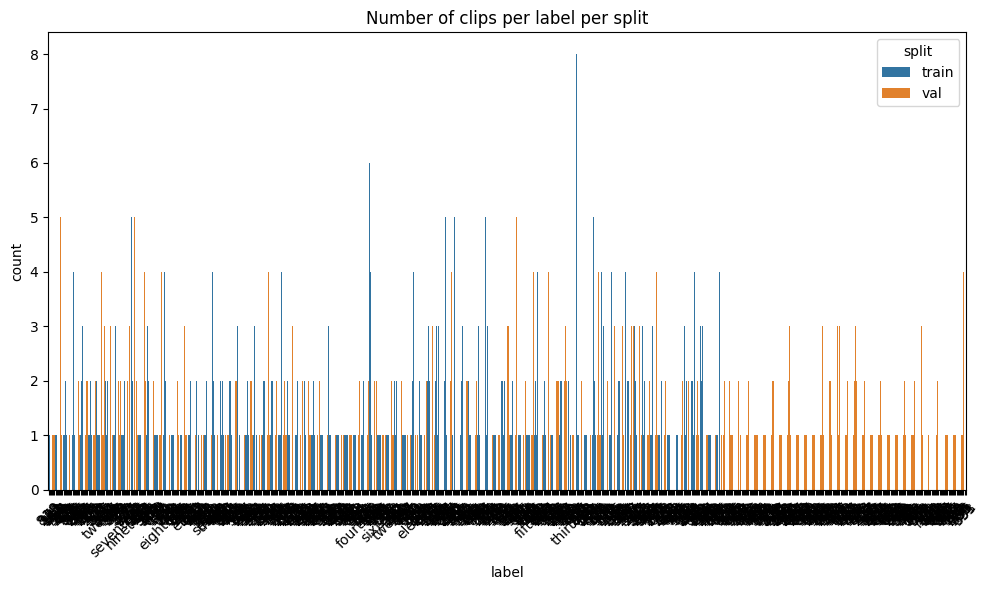

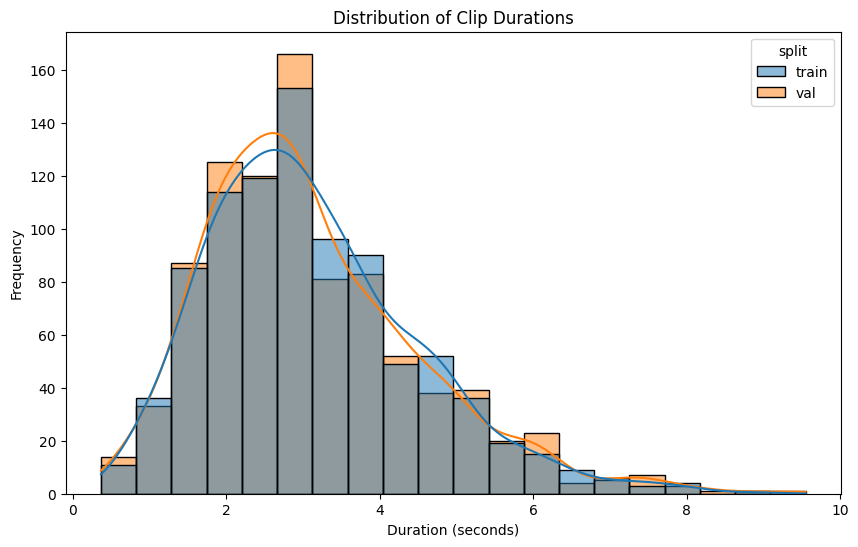

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob


def plot_clip_counts(base_dir):
    split_dirs = ["train", "val", "test"]
    all_counts = []

    for split in split_dirs:
        split_path = os.path.join(base_dir, split)
        
        if not os.path.exists(split_path):
            continue
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            
            if os.path.isdir(label_path):
                clip_count = len(glob.glob(os.path.join(label_path, "*.mp4")))
                all_counts.append({"split": split, "label": label, "count": clip_count})
    
    df_counts = pd.DataFrame(all_counts)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_counts, x="label", y="count", hue="split")
    plt.title("Number of clips per label per split")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_clip_counts(OUTPUT_DIR)

def collect_clip_durations(base_dir):
    durations = []
    
    for root, _, files in os.walk(base_dir):
        for f in files:
            if f.endswith(".mp4"):
                path = os.path.join(root, f)
                cap = cv2.VideoCapture(path)
                fps = cap.get(cv2.CAP_PROP_FPS)
                frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
                duration = frames / fps if fps > 0 else 0
                label = os.path.basename(os.path.dirname(path))
                split = os.path.basename(os.path.dirname(os.path.dirname(path)))
                durations.append({"split": split, "label": label, "duration": duration})
                cap.release()
                
    return pd.DataFrame(durations)

df_durations = collect_clip_durations(OUTPUT_DIR)

plt.figure(figsize=(10, 6))
sns.histplot(data=df_durations, x="duration", hue="split", bins=20, kde=True)
plt.title("Distribution of Clip Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

                                            file  split label  duration  \
0  Dr_Wooten_Signing_Unit_9_Vocabulary_train.mp4  train   819  7.240000   
1  Dr_Wooten_signing_Unit_6_Vocabulary_train.mp4  train   979  2.840000   
2          Unit_19_ASL_UNT_Dori_Reeves_train.mp4  train   281  3.466667   
3                        ASL_Opposites_train.mp4  train   173  3.470137   
4                        ASL_Opposites_train.mp4  train   543  3.503504   

     fps  width  height resolution  
0  25.00    256     256    256x256  
1  25.00    256     256    256x256  
2  30.00    256     256    256x256  
3  29.97    256     256    256x256  
4  29.97    256     256    256x256  


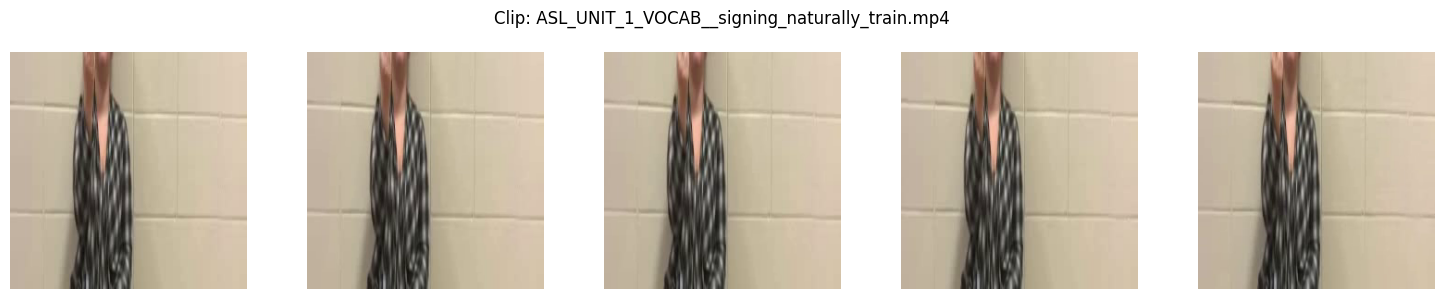

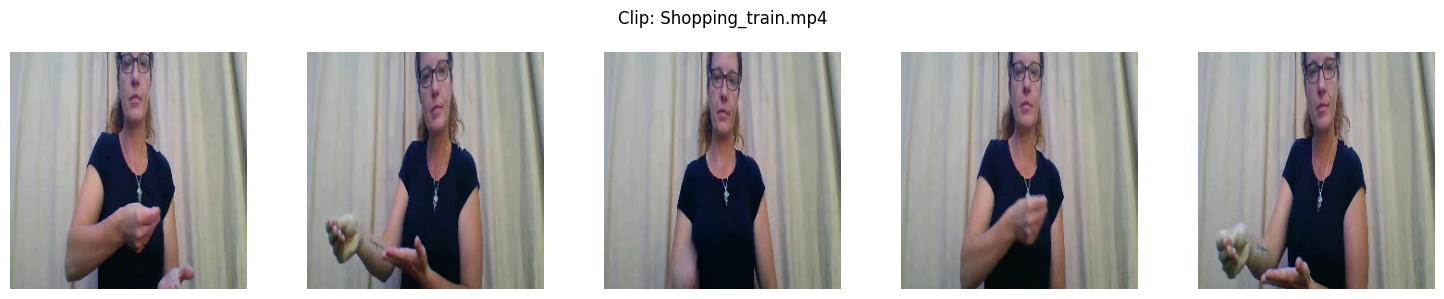

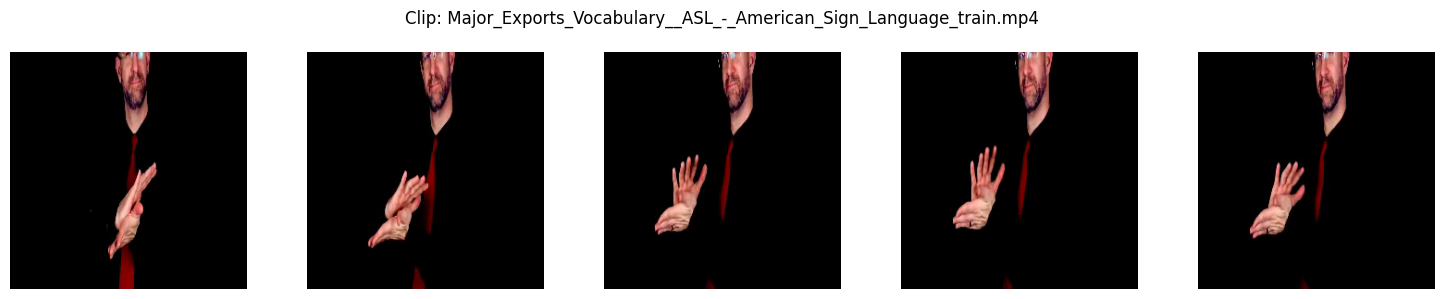

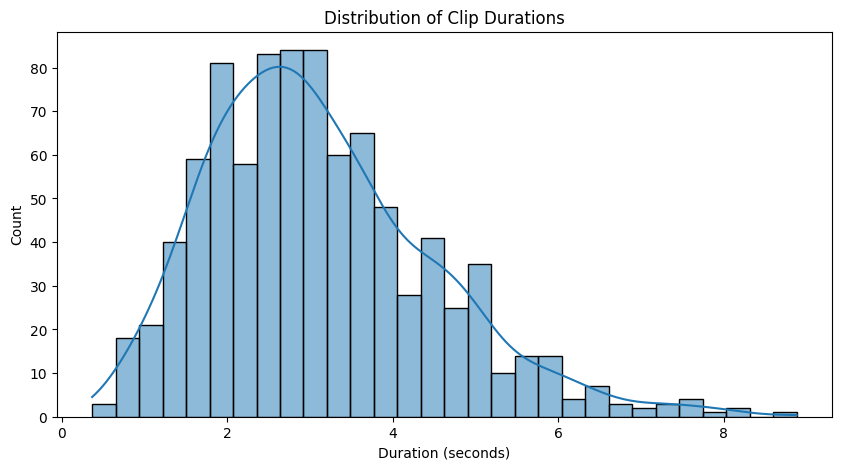

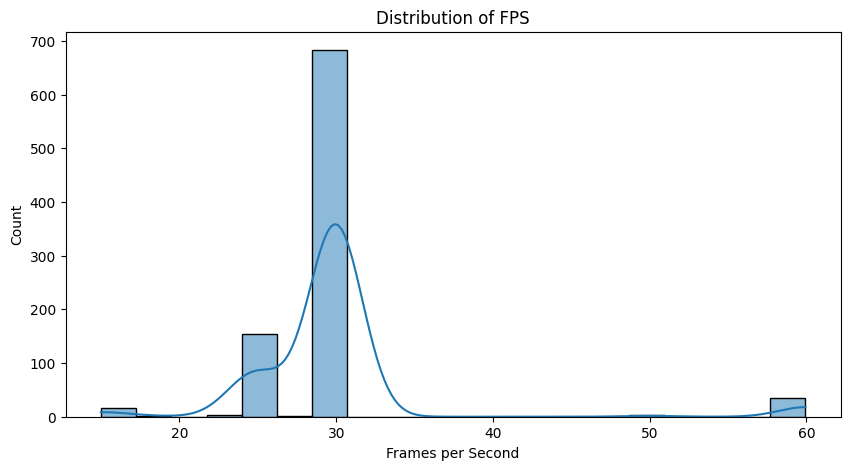

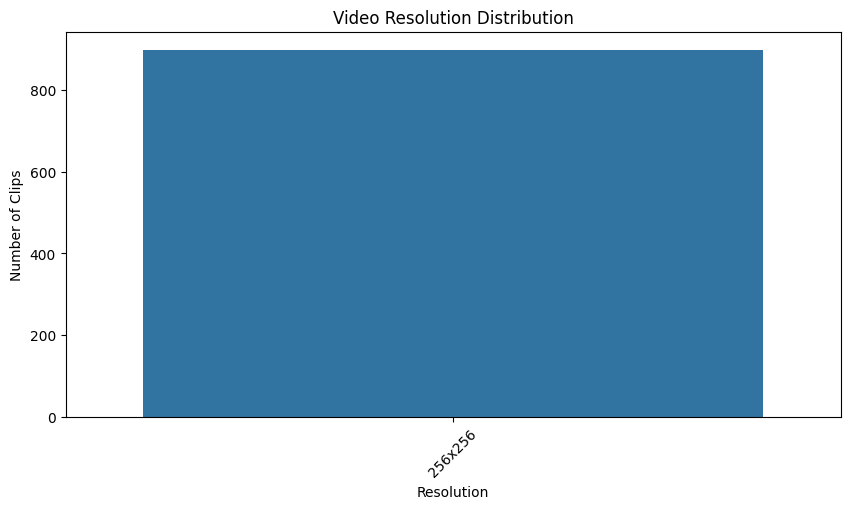

In [4]:
import matplotlib.pyplot as plt
import cv2
import random
import os
import glob
import cv2
import pandas as pd
import seaborn as sns


def show_sample_frames(base_dir, num_clips=3, frames_per_clip=5):
    mp4_files = glob.glob(os.path.join(base_dir, "**", "*.mp4"), recursive=True)
    samples = random.sample(mp4_files, min(num_clips, len(mp4_files)))

    for clip_path in samples:
        cap = cv2.VideoCapture(clip_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(1, total_frames // frames_per_clip)
        frame_indices = [i * step for i in range(frames_per_clip)]
        
        fig, axes = plt.subplots(1, frames_per_clip, figsize=(15, 3))
        fig.suptitle(f"Clip: {os.path.basename(clip_path)}", fontsize=12)

        for i, frame_idx in enumerate(frame_indices):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                axes[i].imshow(frame_rgb)
                axes[i].axis("off")
            else:
                axes[i].set_visible(False)

        cap.release()
        plt.tight_layout()
        plt.show()

def collect_mp4_stats(base_dir):
    stats = []

    for path in glob.glob(os.path.join(base_dir, "**", "*.mp4"), recursive=True):
        cap = cv2.VideoCapture(path)
        
        if not cap.isOpened():
            continue

        frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = frames / fps if fps > 0 else 0
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        label = os.path.basename(os.path.dirname(path))
        split = os.path.basename(os.path.dirname(os.path.dirname(path)))

        stats.append({
            "file": os.path.basename(path),
            "split": split,
            "label": label,
            "duration": duration,
            "fps": fps,
            "width": width,
            "height": height,
            "resolution": f"{width}x{height}",
        })

        cap.release()

    return pd.DataFrame(stats)

df_stats = collect_mp4_stats(OUTPUT_DIR)
print(df_stats.head())
show_sample_frames(OUTPUT_DIR, num_clips=3, frames_per_clip=5)

plt.figure(figsize=(10, 5))
sns.histplot(df_stats["duration"], bins=30, kde=True)
plt.title("Distribution of Clip Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_stats["fps"], bins=20, kde=True)
plt.title("Distribution of FPS")
plt.xlabel("Frames per Second")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=df_stats, x="resolution", order=df_stats["resolution"].value_counts().index)
plt.title("Video Resolution Distribution")
plt.xticks(rotation=45)
plt.ylabel("Number of Clips")
plt.xlabel("Resolution")
plt.show()

In [66]:
import os
import torch
import torch.nn as nn
import random
import numpy as np

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_video
from decord import VideoReader
from decord import cpu


class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=30, class_to_idx=None):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames

        if class_to_idx is None:
            self.classes = sorted(os.listdir(root_dir))
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        else:
            self.class_to_idx = class_to_idx
            self.classes = list(class_to_idx.keys())

        self.video_paths = []
        for label in self.classes:
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for file in os.listdir(label_dir):
                    if file.endswith(".mp4"):
                        self.video_paths.append((os.path.join(label_dir, file), label))

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        for _ in range(5):
            video_path, label = self.video_paths[idx]
            try:
                vr = VideoReader(video_path, ctx=cpu(0))
                total_frames = len(vr)
                
                if total_frames == 0:
                    raise ValueError("Empty video")

                if total_frames >= self.num_frames:
                    indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
                else:
                    indices = list(range(total_frames))
                    
                    while len(indices) < self.num_frames:
                        indices += indices[:self.num_frames - len(indices)]
                        
                frames = vr.get_batch(indices).asnumpy()
                images = [Image.fromarray(frame) for frame in frames]
                
                if self.transform:
                    images = [self.transform(img) for img in images]

                frames_tensor = torch.stack(images)
                label_idx = self.class_to_idx[label]
                
                return frames_tensor, label_idx

            except Exception as e:
                print(f"[Skipped] {video_path}: {e}")
                idx = (idx + 1) % len(self.video_paths)

        dummy = torch.zeros((self.num_frames, 3, 224, 224))
        return dummy, -1

In [67]:
video_transforms_old = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
    transforms.RandomHorizontalFlip(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [68]:
video_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

In [69]:
from torchvision.datasets.folder import find_classes

classes, class_to_idx = find_classes(train_dir)

train_dataset = VideoDataset(train_dir, transform=video_transforms, class_to_idx=class_to_idx)
val_dataset = VideoDataset(val_dir, transform=video_transforms, class_to_idx=class_to_idx)
test_dataset = VideoDataset(test_dir, transform=video_transforms, class_to_idx=class_to_idx)

In [70]:
train_loader = DataLoader(
    train_dataset,
    batch_size=5,  
    shuffle=True,
    num_workers=0,
    persistent_workers=False
)

for frames, labels in train_loader:
    print("Train loader")
    print(f"Frames shape: {frames.shape}")
    print(f"Labels: {labels}")
    break

Train loader
Frames shape: torch.Size([1, 30, 3, 128, 128])
Labels: tensor([26])


In [71]:
val_loader = DataLoader(
    val_dataset,
    batch_size=5,  
    shuffle=True,
    num_workers=0,
    persistent_workers=False
)

for frames, labels in val_loader:
    print("Val Loader")
    print(f"frames shape: {frames.shape}")
    print(f"labels: {labels}")
    break

Val Loader
frames shape: torch.Size([1, 30, 3, 128, 128])
labels: tensor([10])


In [72]:
test_loader = DataLoader(
    test_dataset,
    batch_size=5,  
    shuffle=True,
    num_workers=0,  
    persistent_workers=False
)

for frames, labels in test_loader:
    print("Test Loader")
    print(f"frames shape: {frames.shape}")
    print(f"labels: {labels}")
    break

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
print("Train classes:", train_dataset.class_to_idx)
print("Val classes:  ", val_dataset.class_to_idx)
print("Test classes: ", test_dataset.class_to_idx)

assert train_dataset.class_to_idx == val_dataset.class_to_idx == test_dataset.class_to_idx, \
    "Mismatch in class_to_idx between datasets!"

In [ ]:
from collections import Counter
import os

train_class_counts = Counter()
for path, cls in train_dataset.video_paths:
    train_class_counts[cls] += 1

print(train_class_counts)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetForVideoClassification(nn.Module):
    def __init__(self, num_classes, num_frames=30, dropout_prob=0.5):
        super().__init__()
        self.num_frames = num_frames
        
        base_model = models.resnet18(pretrained=True)
        feature_dim = base_model.fc.in_features
        base_model.fc = nn.Identity()
        self.resnet = base_model

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        batch_size, frames, c, h, w = x.shape
        x = x.view(-1, c, h, w) 

        features = self.resnet(x)  
        features = features.view(batch_size, frames, -1) 
        features = features.mean(dim=1)  

        features = self.dropout(features)
        return self.fc(features)

In [ ]:
from tqdm import tqdm
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_dataset.classes)
num_frames = 30

labels = [train_dataset.classes.index(label) for _, label in train_dataset.video_paths]
class_weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=labels)

weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

model = ResNetForVideoClassification(num_classes=num_classes, num_frames=num_frames).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    scheduler.step()
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training", leave=False)

    for frames, labels in train_bar:
        frames = frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    model.eval()

    val_loss = 0.0
    val_correct = 0
    val_total = 0

    val_bar = tqdm(val_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Validation", leave=False)

    with torch.no_grad():
        for frames, labels in val_bar:
            frames = frames.to(device)
            labels = labels.to(device)
            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            val_bar.set_postfix(loss=loss.item(), acc=100 * val_correct / val_total)

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"\nEpoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%\n")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch

model.eval()
y_true = []
y_pred = []

unnormalize = T.Normalize(mean=[-0.5/0.5]*3, std=[1/0.5]*3)

def show_video_clip(frames_tensor, true_label, pred_label, class_names):
    frames_tensor = frames_tensor.cpu()
    T_frames = frames_tensor.shape[0]

    plt.figure(figsize=(T_frames * 2, 3))

    for t in range(T_frames):
        frame = unnormalize(frames_tensor[t])
        frame = torch.clamp(frame, 0, 1)  
        np_frame = frame.permute(1, 2, 0).numpy()

        plt.subplot(1, T_frames, t + 1)
        plt.imshow(np_frame)
        plt.axis('off')
        plt.title(f"t={t}")

    plt.suptitle(f"True: {class_names[true_label]} | Pred: {class_names[pred_label]}", fontsize=14)
    plt.tight_layout()
    plt.show()

with torch.no_grad():
    for frames, labels in test_loader:
        frames = frames.to(device)
        labels = labels.to(device)
        outputs = model(frames)
        preds = outputs.argmax(dim=1)
        
        mask = labels != -1
        y_true.extend(labels[mask].cpu().numpy())
        y_pred.extend(preds[mask].cpu().numpy())

print(f"Unique classes in y_true: {len(np.unique(y_true))}")
print(f"Classes predicted in y_pred: {np.unique(y_pred)}")

missing_classes = set(test_dataset.classes) - set(np.unique(y_true))
print(f"Missing classes: {missing_classes}")

print(classification_report(y_true, y_pred, target_names=test_dataset.classes, labels=np.unique(y_true)))

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

frames, labels = next(iter(test_loader))
frames = frames.to(device)
outputs = model(frames)
preds = outputs.argmax(dim=1)

for i in range(len(frames)):
    show_video_clip(frames[i], labels[i], preds[i], class_names=test_dataset.classes)
    break 

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()